# IS-4100: NFL Team Performance Analysis using Generalized Linear Models (GLMs)

**Why are GLMs Useful?**
- Flexibility in Modeling Different Types of Data:
  - GLMs can handle various types of response variables:
    - Continuous (Normal distribution)
    - Binary outcomes (Binomial distribution)
    - Counts (Poisson or Negative Binomial distribution)
    - Proportions and more
  - This flexibility allows for modeling data that do not meet the assumptions of traditional linear regression (e.g., non-constant variance, non-normal errors).
- Appropriate for Non-Normal Distributions:
  - Many real-world datasets have response variables that are skewed, bounded, or discrete.
  - GLMs can model these variables appropriately, providing better estimates and inference.
- Interpretability:
  - Coefficients in GLMs can often be interpreted in terms of odds ratios, risk ratios, or rate ratios, which are meaningful in many applied contexts.
- Extensibility:
  - GLMs form the foundation for more advanced models like Generalized Linear Mixed Models (GLMMs), allowing for random effects and hierarchical data structures.
- Modeling Non-Linear Relationships:
  - Through the use of link functions, GLMs can model non-linear relationships between the predictors and the response variable.

In this lab, you will analyze NFL team performance data using Generalized Linear Models (GLMs). You'll utilize the `nfl_data_py` or `nflfastR` to perform your analysis.

**Learning Objectives**
- Data Retrieval: Learn how to fetch and manipulate NFL data using `nfl_data_py` or `nflfastR`.
- Data Preprocessing: Clean and prepare the dataset for modeling.
- GLM Modeling: Understand and apply GLMs to model NFL team performance.
- Interpretation: Interpret the results of your GLM and derive meaningful insights.

**Assignment Overview**

You will perform the following tasks:

- Setup and Data Retrieval
- Data Preprocessing / EDA
  - Build upon feedback and extra functions / methods we have covered in class.
- GLM Modeling
  - Choose an appropriate GLM for modeling team performance.
  - Fit the model and check for assumptions.
- Results Interpretation
  - Analyze the output of your GLM.
  - Discuss the implications of your findings.
- Reporting
  - Summarize your methodology, results, and conclusions in a brief report.

**Extra Resources**
- [nfl_data_py Documentation](https://pypi.org/project/nfl-data-py/)
- [nflfastR Documentation](https://www.nflfastr.com/)
- [nflfastR Data Dictionary](https://www.nflfastr.com/articles/field_descriptions.html)
- [Generalized Linear Models in Python: A Comprehensive Guide](https://statisticseasily.com/generalized-linear-models-in-python/#google_vignette)
- [GLM guide in R](https://albert-rapp.de/posts/14_glms/14_glms)

**Potential Areas to Explore**
- Predicting Touchdown Probability
  - Estimate the probability of a play resulting in a touchdown based on game and play characteristics.
  - Model: Logistic Regression.
- Estimating Player Performance with Poisson Regression
  - Predict the number of tackles a defensive player makes in a game (count data).
- Assessing Penalty Likelihood
  - Predict the probability of a penalty occurring on a play.
  - Model: Logistic Regression
- Evaluating Defensive Sack Rates
  - Analyze factors that contribute to the likelihood of a quarterback sack.
  - Model: Logistic Regression.
- Modeling Over/Under Betting Outcomes
  - Objective: Predict if the total game score will be over or under the bookmaker's line.
  - Model: Logistic Regression.

## Setup & Data Retrieval

In [1]:
# install packages
install.packages("nflfastR")
install.packages("tidyverse")
install.packages("ggplot2")
install.packages("dplyr")
install.packages("nflreadr")
install.packages("ggpubr")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘globals’, ‘listenv’, ‘parallelly’, ‘snakecase’, ‘fastrmodels’, ‘furrr’, ‘future’, ‘janitor’, ‘nflreadr’, ‘progressr’, ‘xgboost’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Deriv’, ‘microbenchmark’, ‘numDeriv’, ‘doBy’, ‘SparseM’, ‘MatrixModels’, ‘minqa’, ‘nloptr’, ‘RcppEigen’, ‘carData’, ‘abind’, ‘Formula’, ‘pbkrtest’, ‘quantreg’, ‘lme4’, ‘corrplot’, ‘car’, ‘ggrepel’, ‘ggsci’, ‘cowplot’, ‘ggsignif’, ‘gridExtra’, ‘polynom’, ‘rstatix’




In [2]:
library(tidyverse)
library(nflfastR)
library(broom)
library(nflreadr)
library(ggpubr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘nflreadr’


The following objects are masked from ‘package:nflfastR’:

    load_pbp, load_player_stats




In [3]:
options(repr.plot.width = 20, repr.plot.height = 10)

## Data Processing & EDA

In [4]:
# load pbp data
pbp <- load_pbp(2016:2024)

# load schedule data
schedules <- load_schedules(2016:2024)

In [5]:
# list of my teams' abbreviations
my_teams <- c('BAL', 'NYJ', 'JAX', 'DAL','LV', 'LA', 'CAR', 'DET')

In [6]:
# filter schedule data
schedules_my_teams <- schedules |>
  filter((home_team %in% my_teams | away_team %in% my_teams) & !is.na(home_score) & season == 2024)

### Total Sack and QB Hit Percentage

In [7]:
# get data for total sack percentage
sack_pct_total <- pbp |>
  filter(defteam %in% my_teams & season == 2024 & week > 0) |>
  drop_na(defteam) |>
  group_by(defteam) |>
  summarise(
    sacks = sum(sack, na.rm = TRUE),
    qb_hits = sum(qb_hit, na.rm = TRUE),
    plays = n(),
    sack_pct = sacks / plays * 100,
    qb_hit_pct = qb_hits / plays * 100
  )

sack_pct_total |>
  arrange(-sack_pct)

defteam,sacks,qb_hits,plays,sack_pct,qb_hit_pct
<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
NYJ,20,33,490,4.081633,6.734694
BAL,19,46,493,3.853955,9.330629
DET,15,39,421,3.562945,9.263658
DAL,14,34,500,2.800000,6.800000
LV,14,30,503,2.783300,5.964215
JAX,14,28,516,2.713178,5.426357
LA,9,15,402,2.238806,3.731343
CAR,6,16,498,1.204819,3.212851


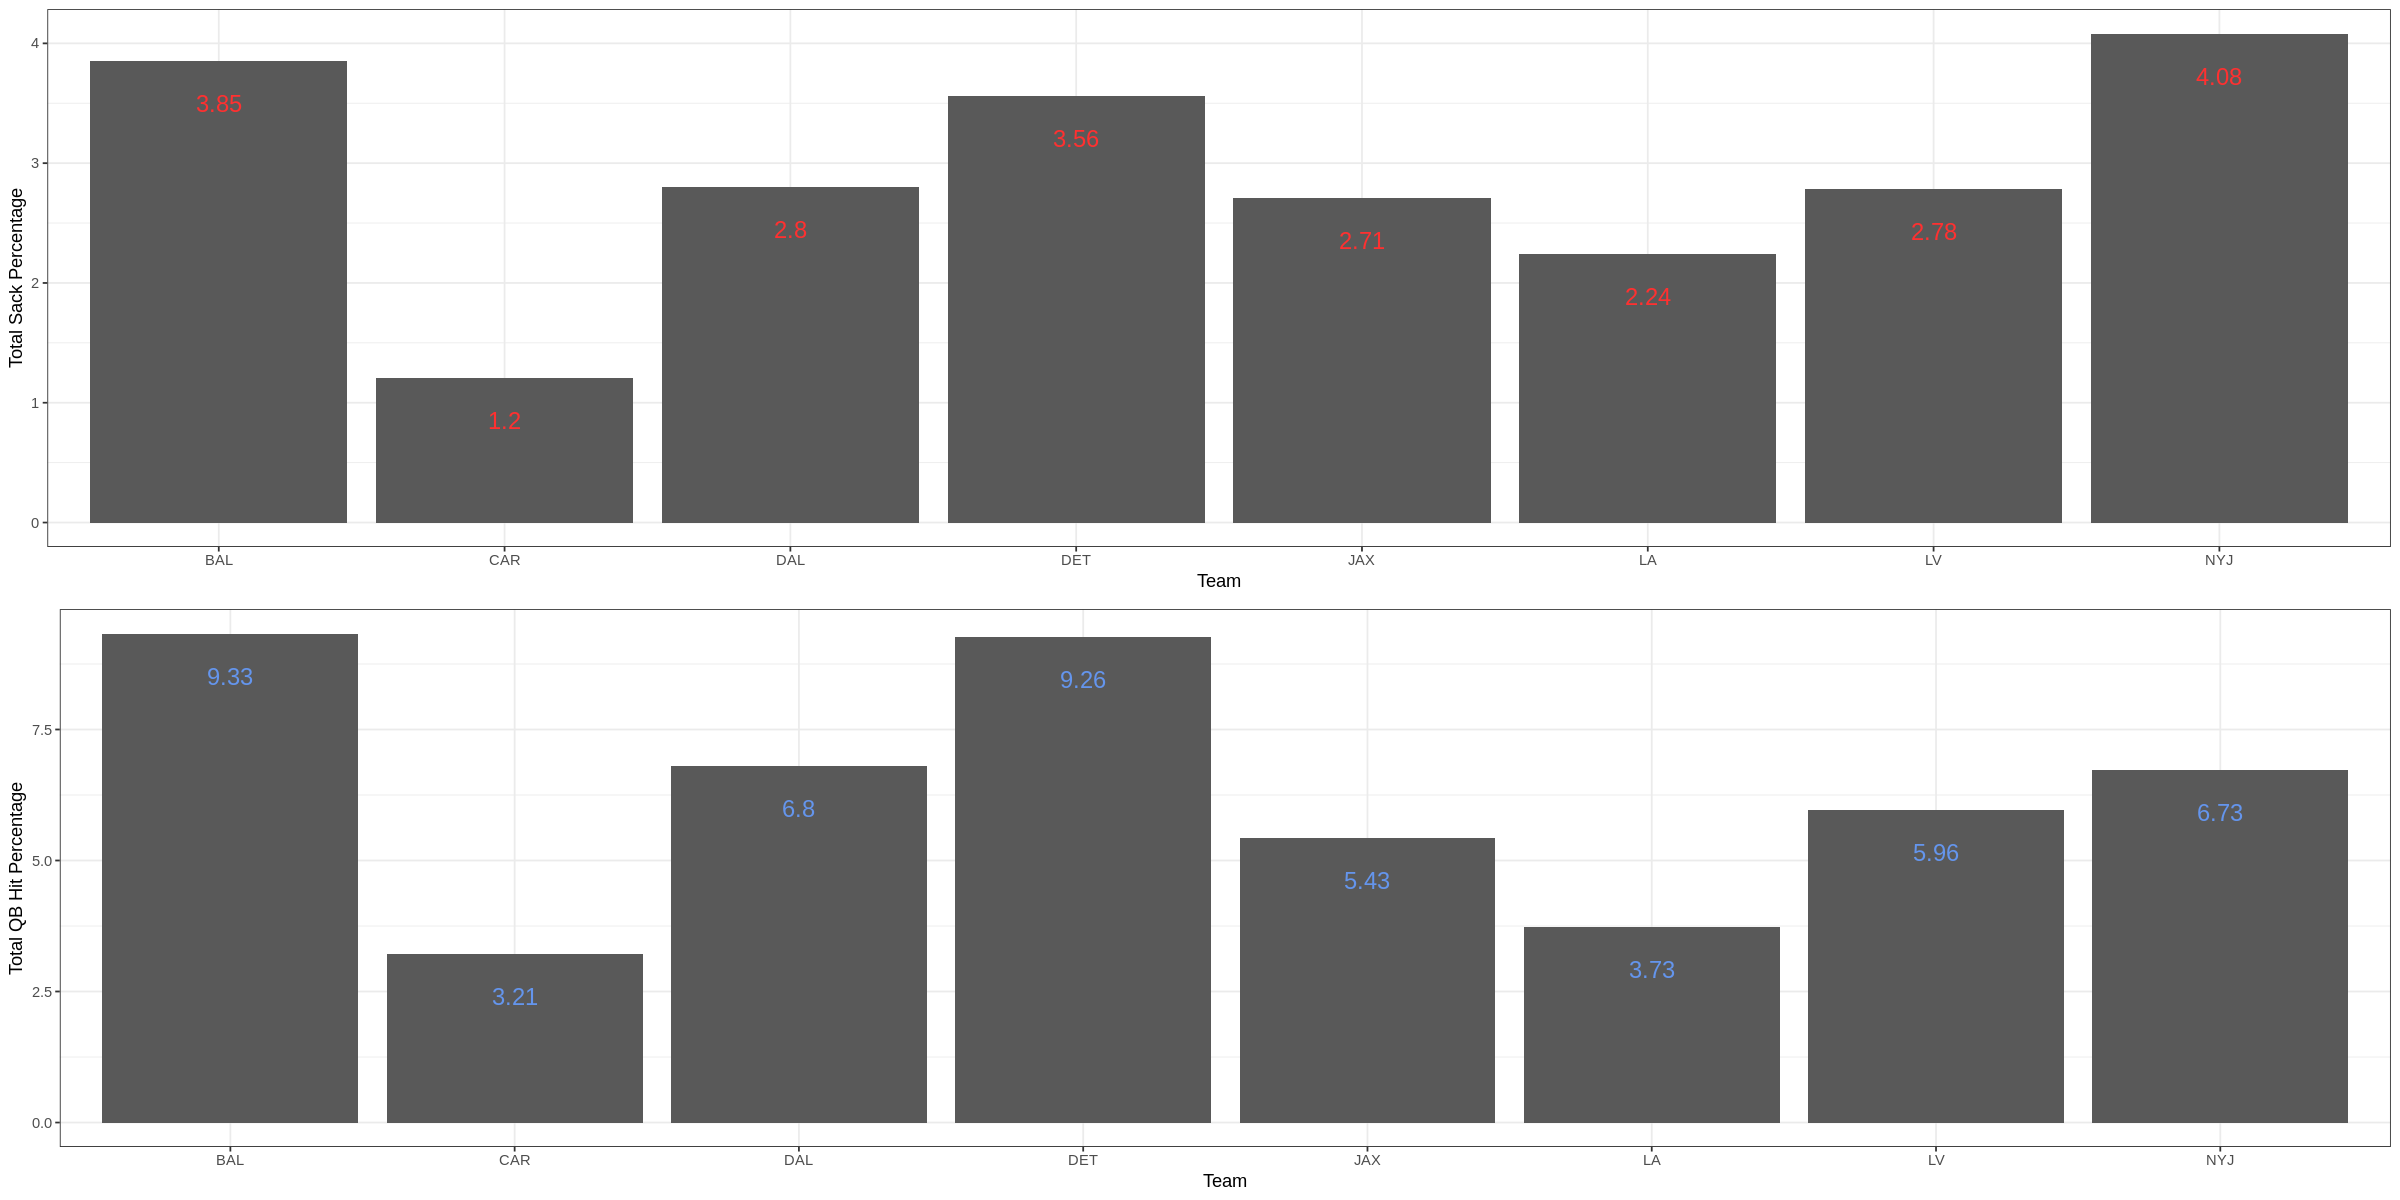

In [8]:
# plot total sack percentage
total_sack_pct <- ggplot(sack_pct_total, aes(x = defteam, y = sack_pct)) +
  geom_bar(stat = "identity") +
  theme_bw() +
  xlab("Team") +
  ylab("Total Sack Percentage") +
  geom_text(aes(label = round(sack_pct, 2)), color = "firebrick1", vjust = 3, size = 5)

# plot total qb hit percentage
total_qb_hit_pct <- ggplot(sack_pct_total, aes(x = defteam, y = qb_hit_pct)) +
  geom_bar(stat = "identity") +
  theme_bw() +
  xlab("Team") +
  ylab("Total QB Hit Percentage") +
  geom_text(aes(label = round(qb_hit_pct, 2)), color = "cornflowerblue", vjust = 3, size = 5)

# show plots, one on top of the other
ggarrange(total_sack_pct, total_qb_hit_pct, nrow = 2)

### Sack and QB Hit Percentage by Down

In [9]:
sack_pct_data <- pbp |>
  filter(season == 2024 & week > 0) |>
  filter(defteam %in% my_teams) |>
  group_by(defteam, down) |>
  drop_na(defteam, down) |>
  summarise(
    sacks = sum(sack, na.rm = TRUE),
    qb_hits = sum(qb_hit, na.rm = TRUE),
    plays = n(),
    sack_pct = sacks/plays * 100,
    qb_hit_pct = qb_hits / plays * 100
  )

`summarise()` has grouped output by 'defteam'. You can override using the
`.groups` argument.


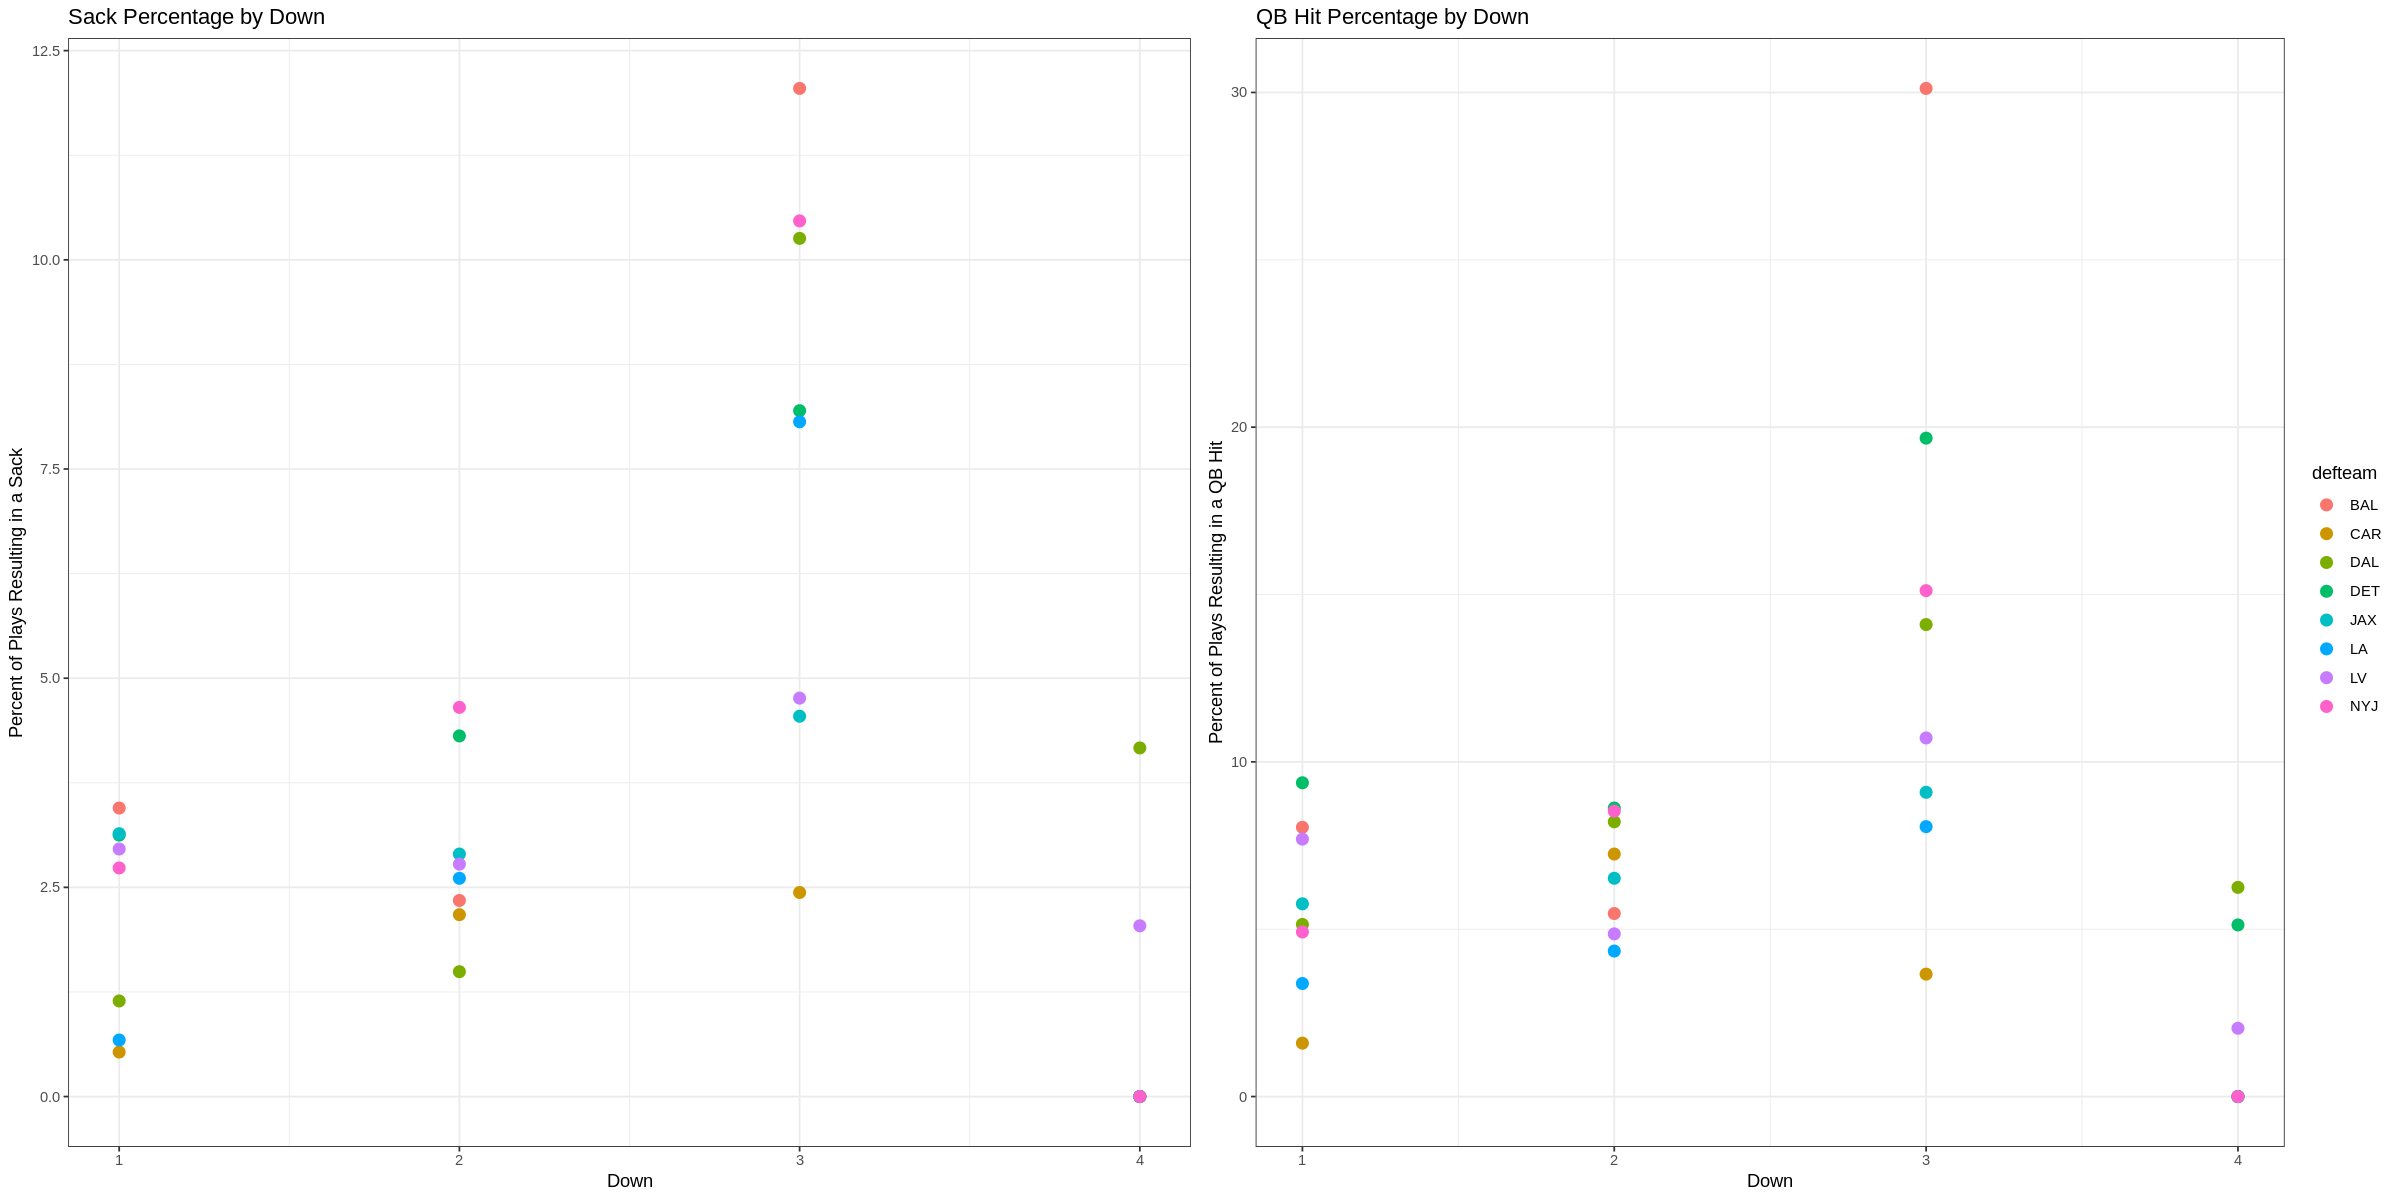

In [10]:
# plot down and sack percentage
sack_pct_plot <- ggplot(sack_pct_data, aes(x = down, y = sack_pct, color = defteam)) +
  geom_point(size = 3) +
  theme_bw() +
  theme(legend.position = 'none') +
  xlab("Down") +
  ylab("Percent of Plays Resulting in a Sack") +
  ggtitle("Sack Percentage by Down")

# plot down and qb hit percentage
qb_hit_pct_plot <- ggplot(sack_pct_data, aes(x = down, y = qb_hit_pct, color = defteam)) +
  geom_point(size = 3) +
  theme_bw() +
  xlab("Down") +
  ylab("Percent of Plays Resulting in a QB Hit") +
  ggtitle("QB Hit Percentage by Down")

# output both plots
ggarrange(sack_pct_plot, qb_hit_pct_plot, ncol = 2)

### Sack by Score Differential, Yards to Go, and Yardline

In [11]:
sack_df <- pbp |>
  filter(defteam %in% my_teams) |>
  filter(season == 2024 & week > 0) |>
  drop_na(down, sack) |>
  select(
    posteam,
    posteam_score,
    defteam,
    defteam_score,
    down,
    yardline_100,
    ydstogo,
    sack,
    qb_hit
  ) |>
  mutate(
    point_dif = defteam_score - posteam_score
  )

head(sack_df)

posteam,posteam_score,defteam,defteam_score,down,yardline_100,ydstogo,sack,qb_hit,point_dif
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
KC,0,BAL,7,1,67,10,0,0,7
KC,0,BAL,7,1,56,10,1,1,7
KC,0,BAL,7,2,56,10,0,0,7
KC,0,BAL,7,3,52,6,0,0,7
KC,0,BAL,7,1,21,10,0,0,7
KC,7,BAL,7,1,90,10,0,1,0


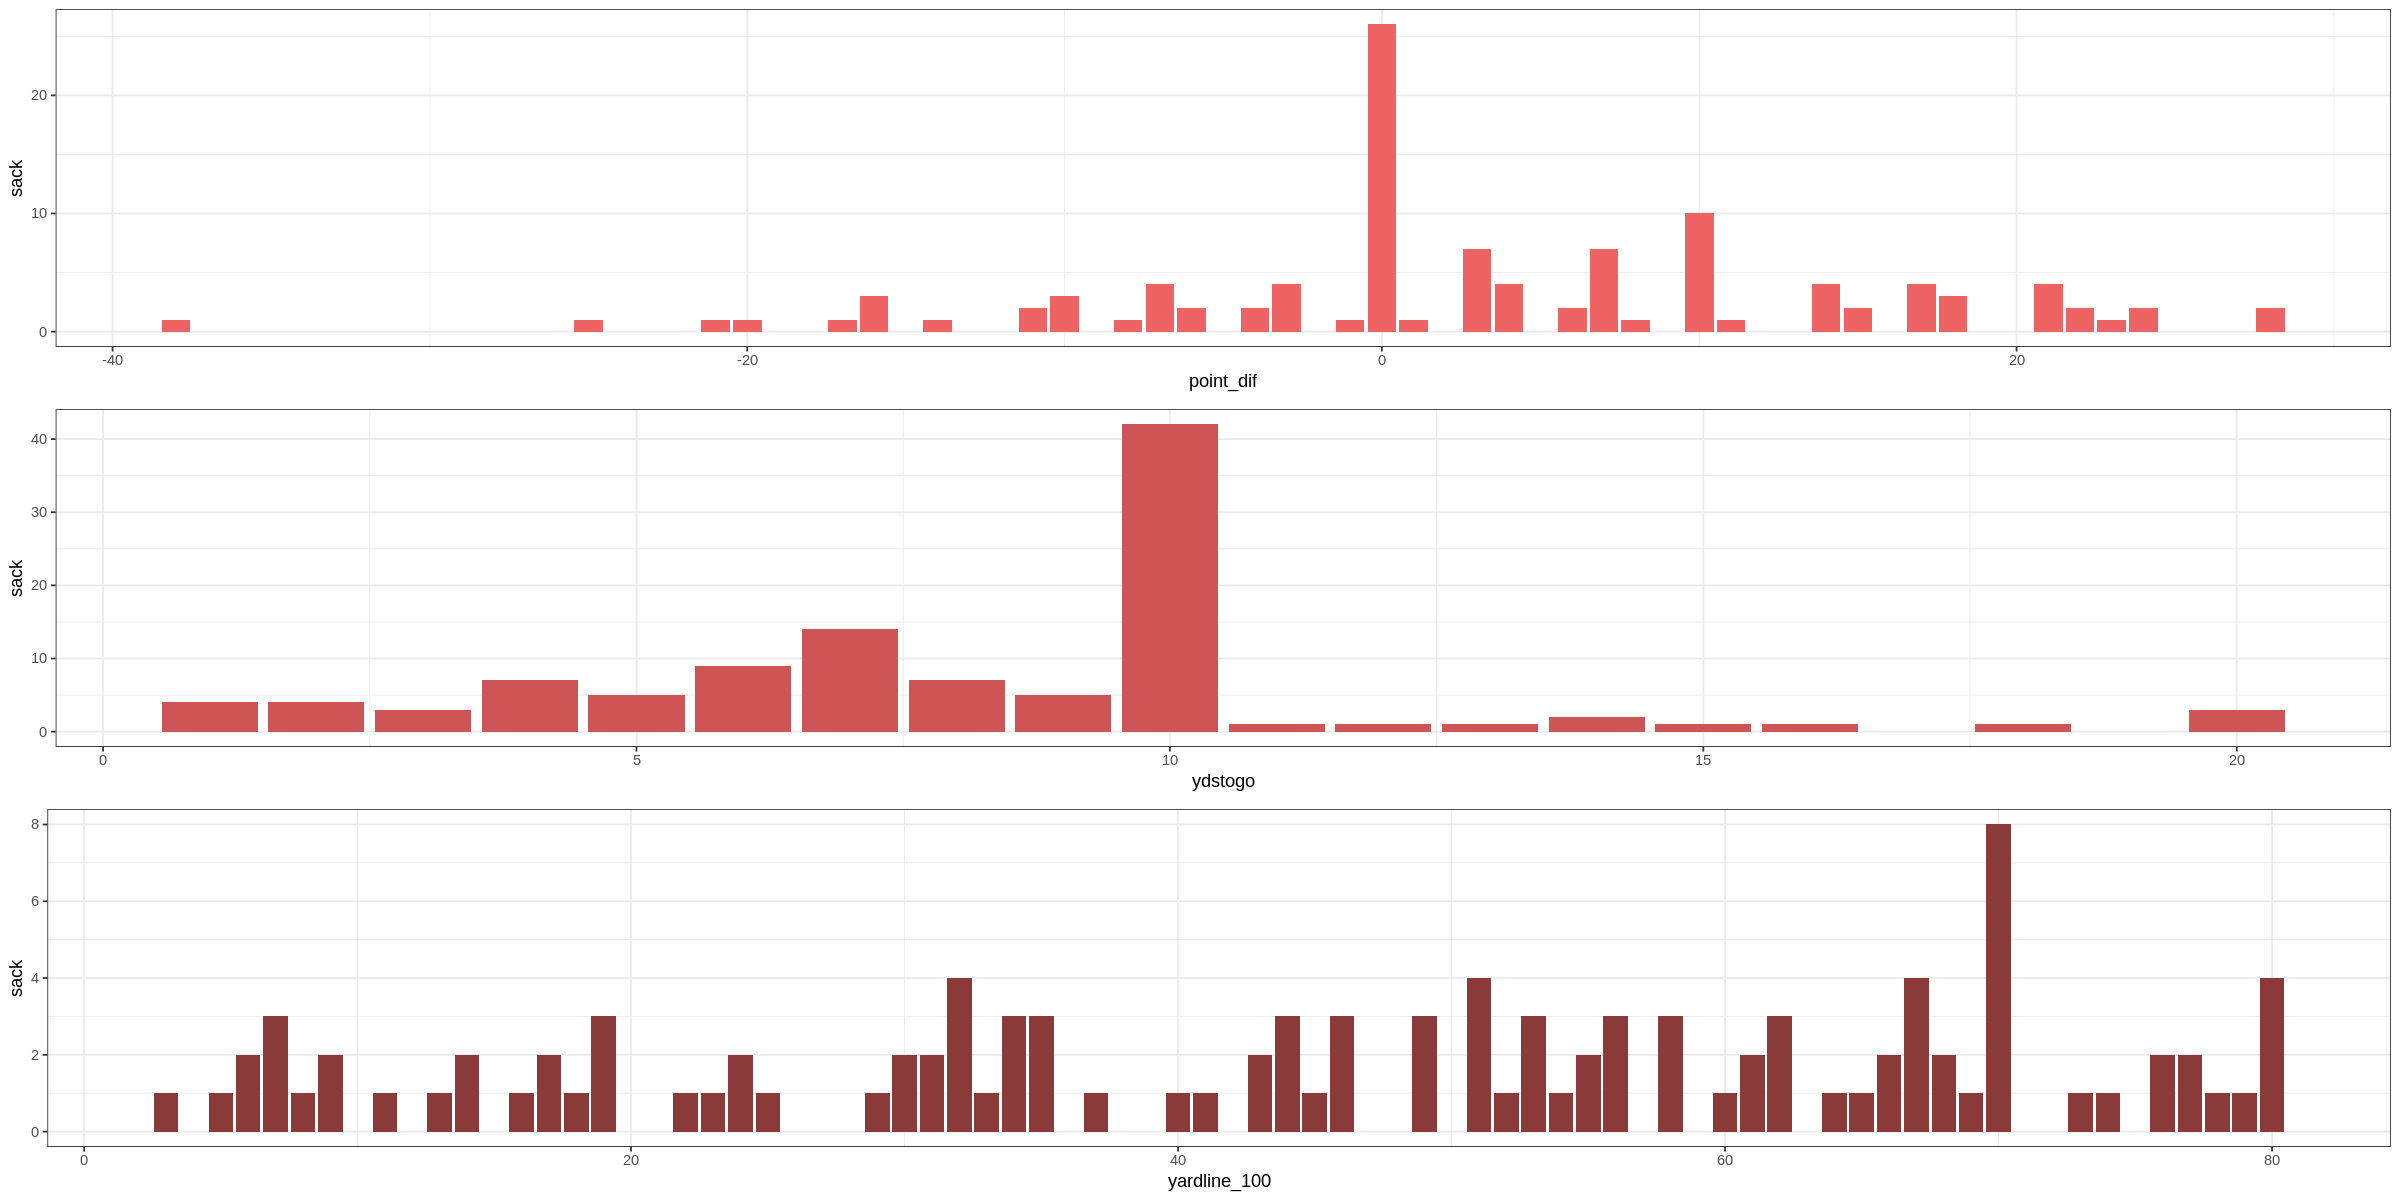

In [12]:
# plot sacks by score diff, yards to go, yardline
score_diff_plot <- ggplot(sack_df |> filter(sack == 1), aes(x = point_dif, y = sack)) +
  geom_bar(stat = "identity", fill = "indianred2") +
  theme_bw() +
  theme(legend.position = 'none')

ydstogo_plot <- ggplot(sack_df |> filter(sack == 1), aes(x = ydstogo, y = sack)) +
  geom_bar(stat = "identity", fill = "indianred3") +
  theme_bw() +
  theme(legend.position = 'none')

yardline_plot <- ggplot(sack_df |> filter(sack == 1), aes(x = yardline_100, y = sack)) +
  geom_bar(stat = "identity", fill = "indianred4") +
  theme_bw() +
  theme(legend.position = 'none')

ggarrange(score_diff_plot, ydstogo_plot, yardline_plot, nrow = 3)

### QB Hit by Score Differential, Yards to Go, and Yardline

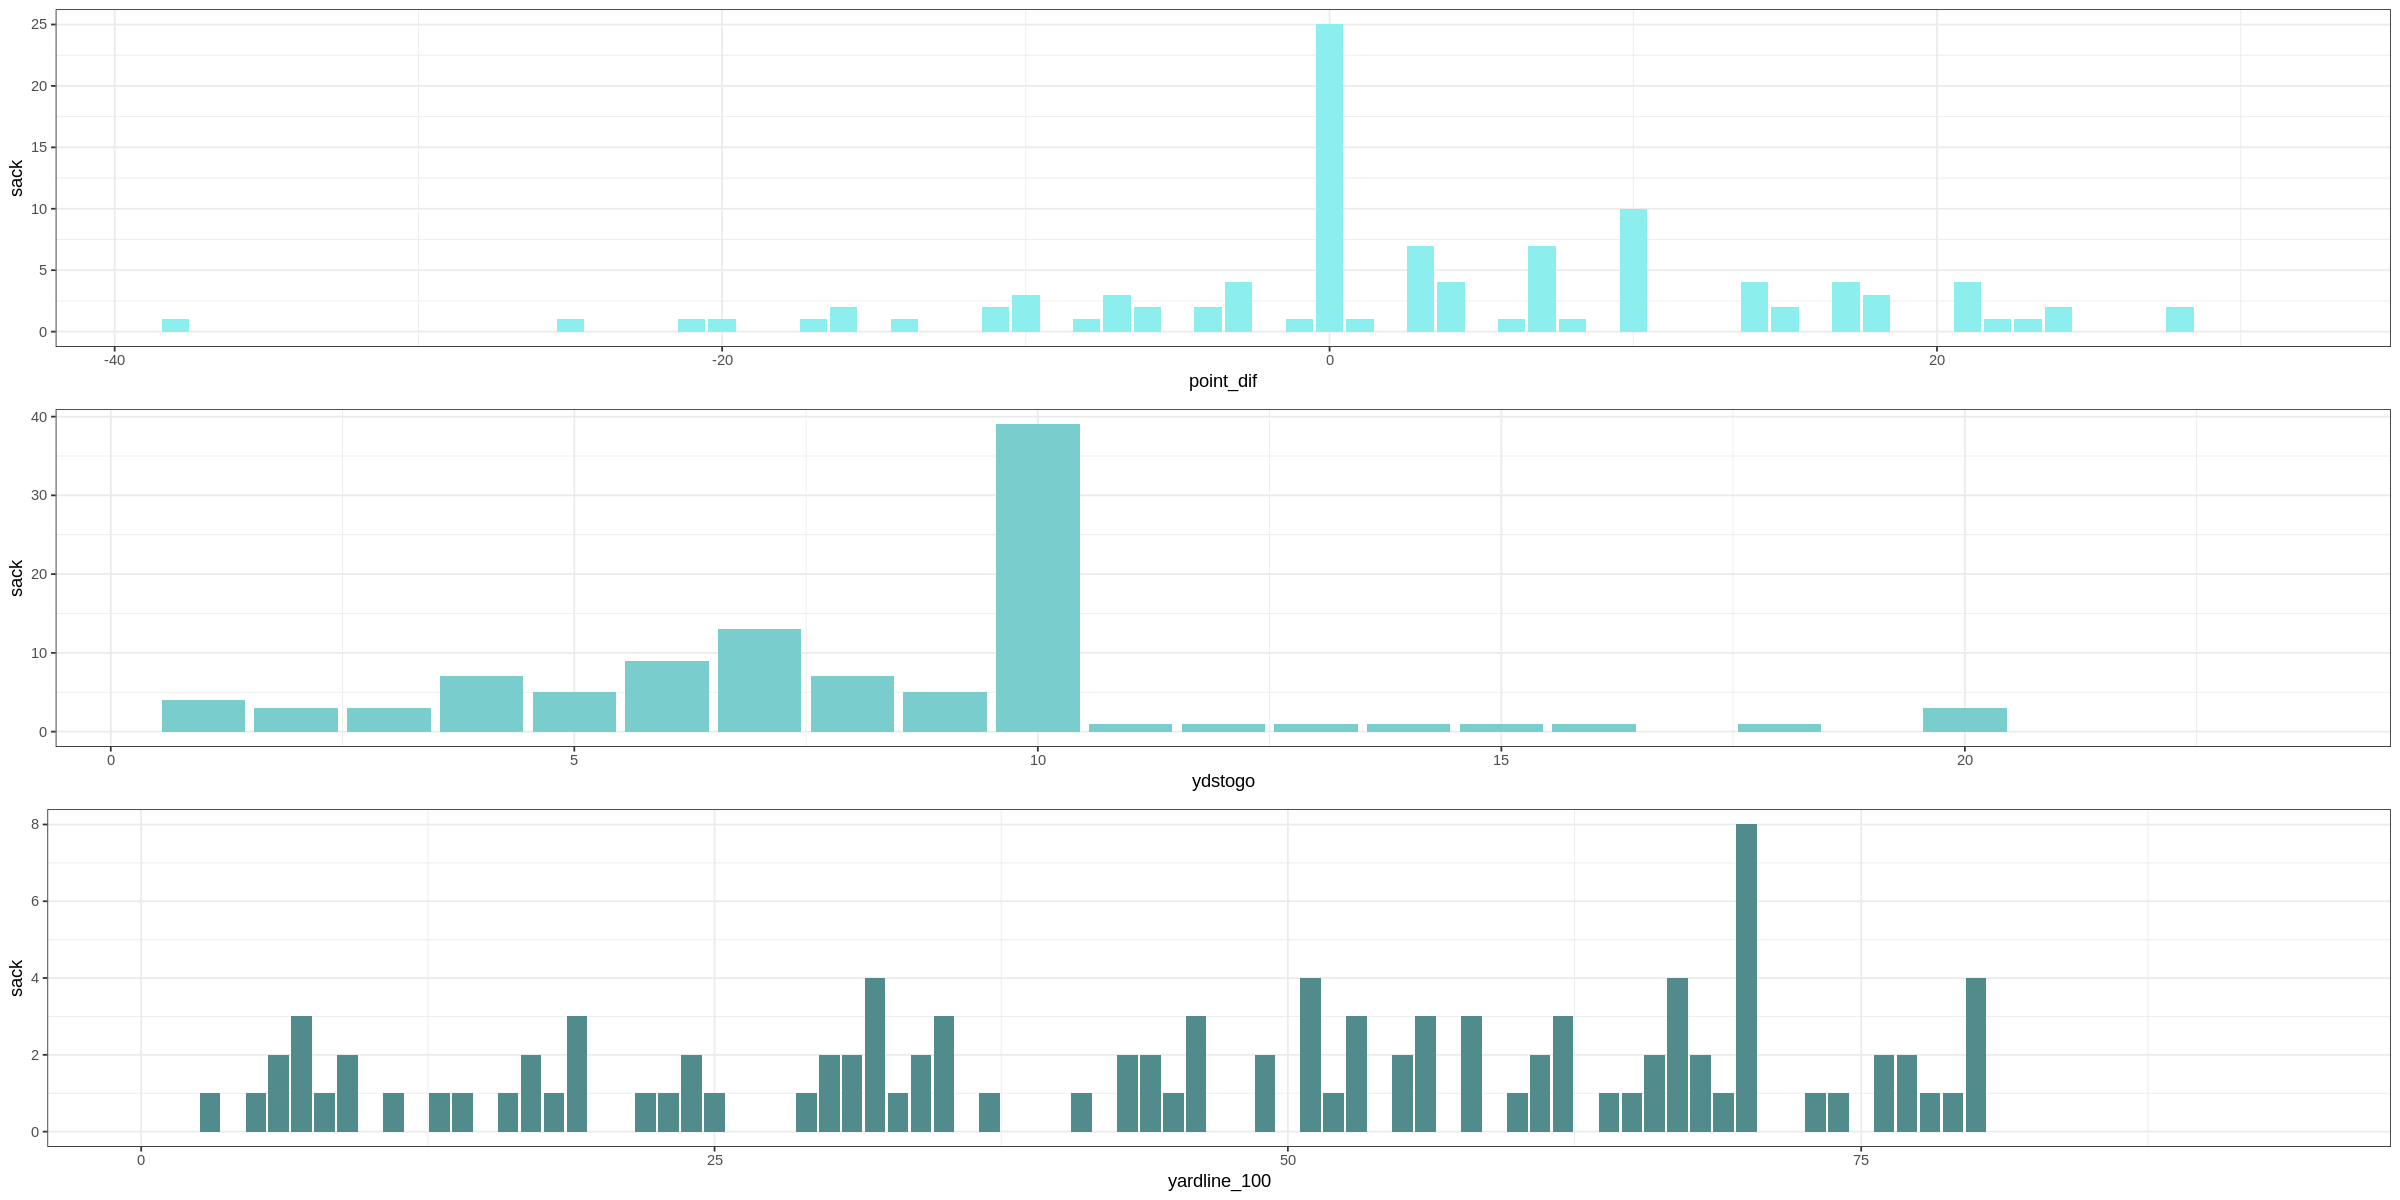

In [13]:
# plot qb hits by score diff, yards to go, yardline
score_diff_plot <- ggplot(sack_df |> filter(qb_hit == 1), aes(x = point_dif, y = sack)) +
  geom_bar(stat = "identity", fill = "darkslategray2") +
  theme_bw() +
  theme(legend.position = 'none')

ydstogo_plot <- ggplot(sack_df |> filter(qb_hit == 1), aes(x = ydstogo, y = sack)) +
  geom_bar(stat = "identity", fill = "darkslategray3") +
  theme_bw() +
  theme(legend.position = 'none')

yardline_plot <- ggplot(sack_df |> filter(qb_hit == 1), aes(x = yardline_100, y = sack)) +
  geom_bar(stat = "identity", fill = "darkslategray4") +
  theme_bw() +
  theme(legend.position = 'none')

ggarrange(score_diff_plot, ydstogo_plot, yardline_plot, nrow = 3)

## GLM Modeling

### Basic GLM

In [14]:
# create simple glm model based solely off down
glm_down <- glm(
  data = sack_df,
  sack ~ down,
  family = "binomial"
)

summary(glm_down)


Call:
glm(formula = sack ~ down, family = "binomial", data = sack_df)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -3.85197    0.22371 -17.218   <2e-16 ***
down         0.22631    0.09217   2.455   0.0141 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 976.49  on 3376  degrees of freedom
Residual deviance: 970.64  on 3375  degrees of freedom
AIC: 974.64

Number of Fisher Scoring iterations: 6


In [15]:
# get the odds
cat("Odds: ", exp(glm_down$coefficients[2]))

Odds:  1.25396

`geom_smooth()` using formula = 'y ~ x'


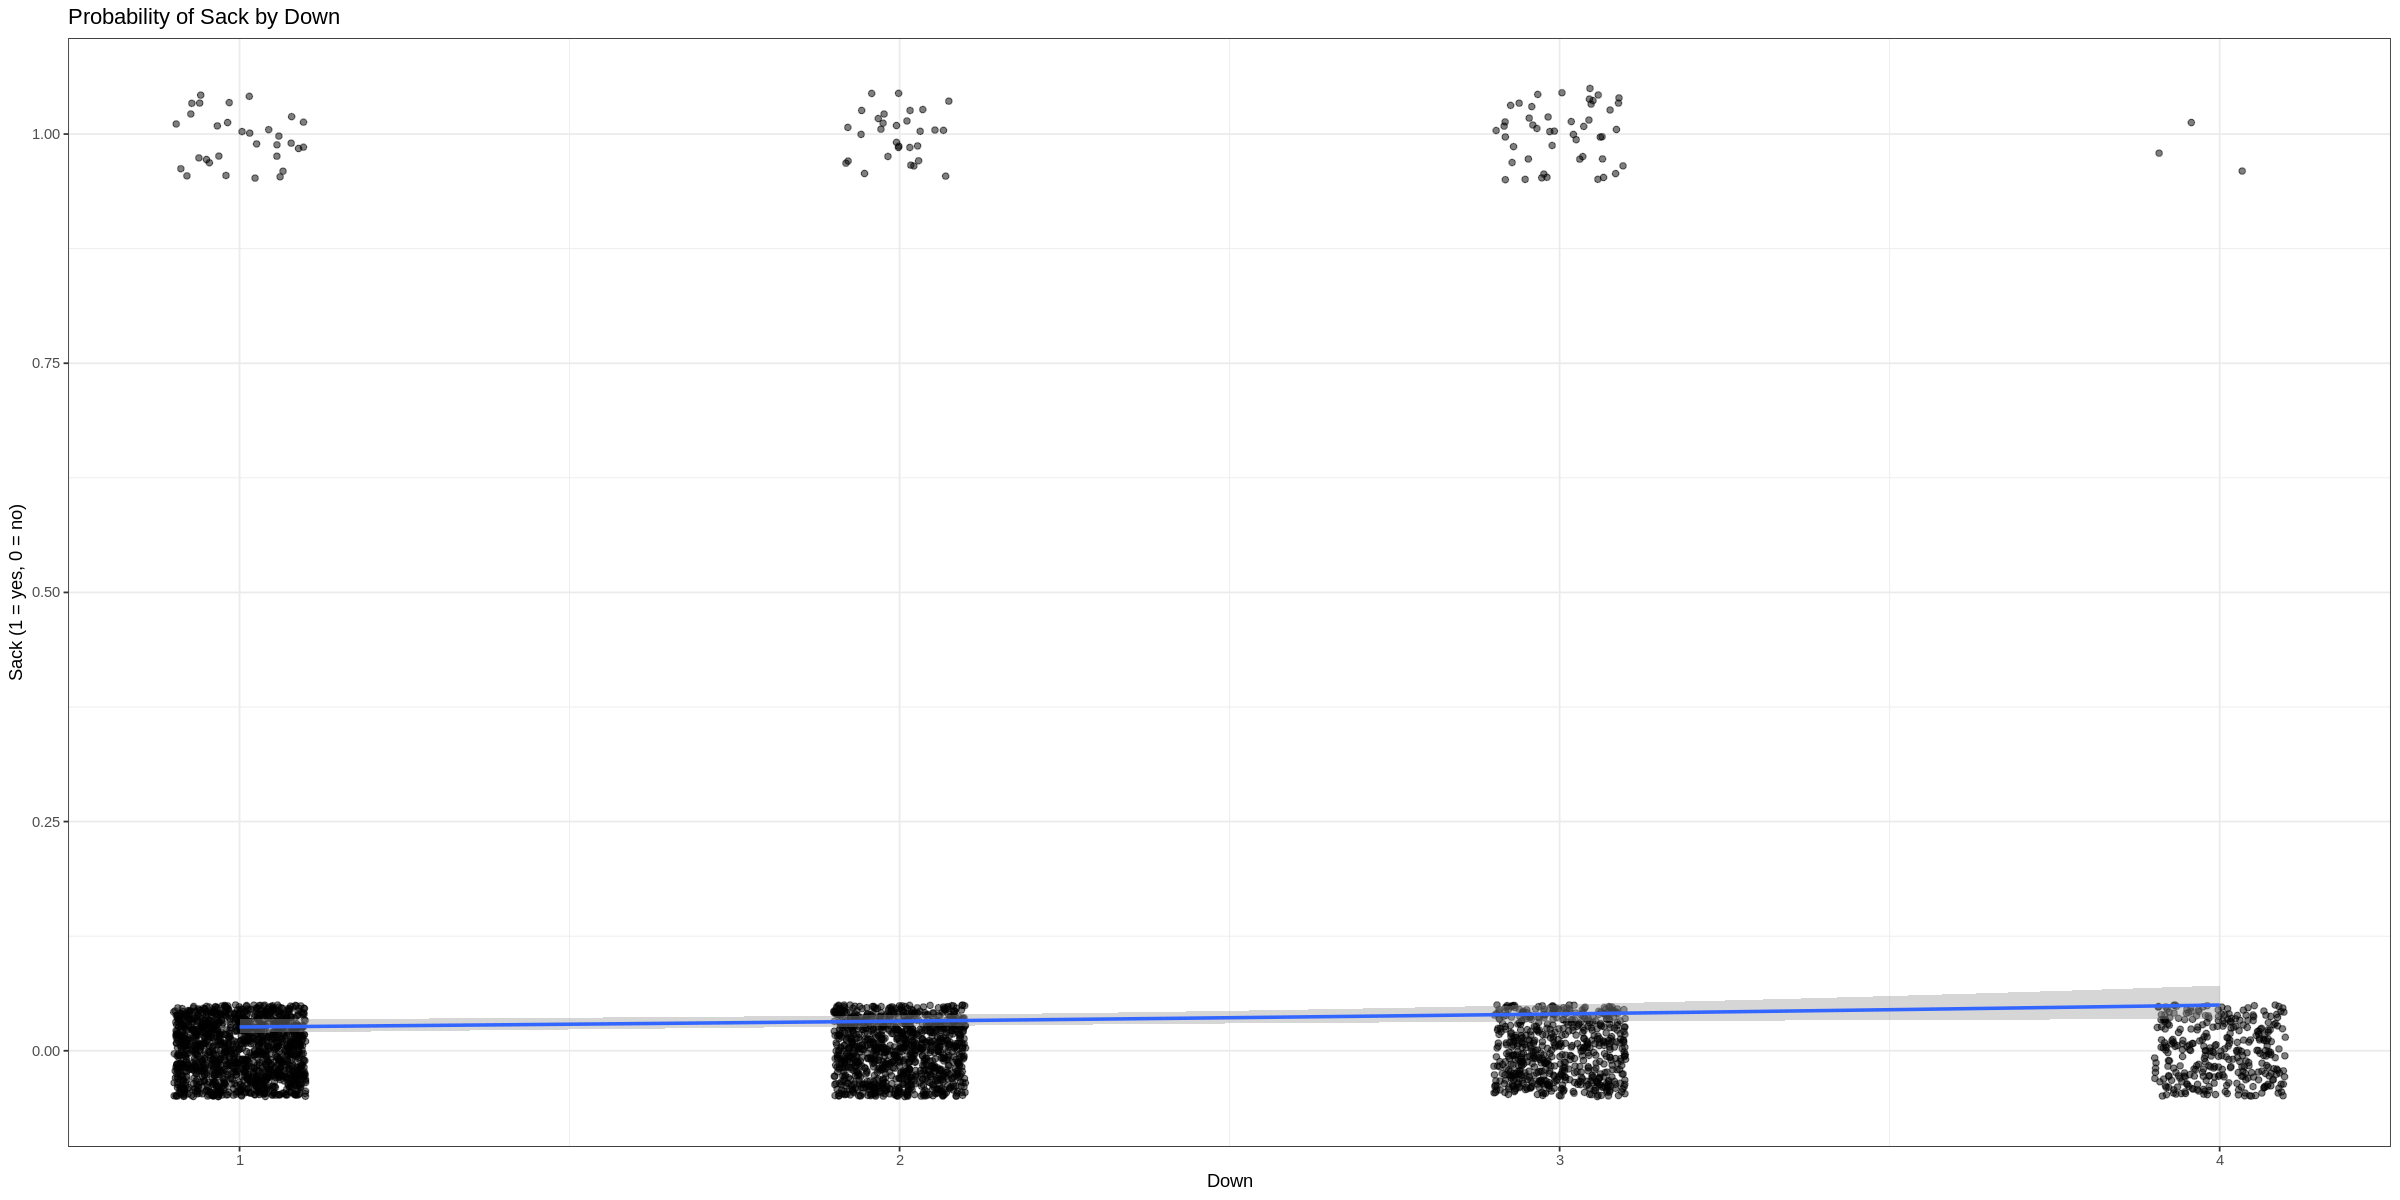

In [16]:
# logistic plot
ggplot(data = sack_df, aes(x = down, y = sack)) +
  geom_jitter(height = 0.05, width = 0.1, alpha = 0.5) +
  stat_smooth(method = 'glm',
      method.args = list(family = "binomial")) +
  theme_bw() +
  xlab("Down") +
  ylab("Sack (1 = yes, 0 = no)") +
  ggtitle("Probability of Sack by Down")

### Complete GLM

In [17]:
# create glm using down, score diff, yardline, ydstogo
complete_glm <- glm(
  data = sack_df,
  formula = sack ~ down*ydstogo +
    yardline_100 + point_dif,
  family = "binomial"
)

summary(complete_glm)


Call:
glm(formula = sack ~ down * ydstogo + yardline_100 + point_dif, 
    family = "binomial", data = sack_df)

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -4.069941   0.638684  -6.372 1.86e-10 ***
down          0.418997   0.219508   1.909   0.0563 .  
ydstogo       0.057120   0.063926   0.894   0.3716    
yardline_100 -0.007021   0.004185  -1.678   0.0934 .  
point_dif     0.032261   0.008254   3.909 9.28e-05 ***
down:ydstogo -0.022624   0.022530  -1.004   0.3153    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 976.49  on 3376  degrees of freedom
Residual deviance: 952.49  on 3371  degrees of freedom
AIC: 964.49

Number of Fisher Scoring iterations: 6


In [18]:
complete_glm |>
  tidy()

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-4.069940995,0.638684422,-6.3723818,1.861148e-10
down,0.418996836,0.219508416,1.9087962,5.628838e-02
ydstogo,0.057120030,0.063925821,0.8935361,3.715701e-01
yardline_100,-0.007021347,0.004184931,-1.6777689,9.339222e-02
point_dif,0.032260545,0.008253788,3.9085745,9.284233e-05
down:ydstogo,-0.022624498,0.022529595,-1.0042124,3.152763e-01


In [19]:
complete_glm |>
  tidy(exponentiate = TRUE)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.0170784,0.638684422,-6.3723818,1.861148e-10
down,1.5204355,0.219508416,1.9087962,5.628838e-02
ydstogo,1.0587829,0.063925821,0.8935361,3.715701e-01
yardline_100,0.9930032,0.004184931,-1.6777689,9.339222e-02
point_dif,1.0327866,0.008253788,3.9085745,9.284233e-05
down:ydstogo,0.9776295,0.022529595,-1.0042124,3.152763e-01


## Results Interpretation

### Basic GLM

*Down* is a significant predictor (p < 0.05) and has a coefficient (log-odds) value of **0.226**.  By exponentiating this value, we find that the odds change at a factor of about 1.25 as the down increases.  To put this more simply, **for each increase in down, the odds of a sack goes up by about 25%**.  However, as we can see from the logistic plot, the chances of getting a sack are always quite low.

### Complete GLM

In the complete model, using *down*, *ydstogo*, *yardline_100*, *point_dif*, and the interaction between *down* and *ydstogo*, only *point_dif* was a significant predictor.  *Down* (0.056) and *yardline_100* (0.093) were close to the 0.05 threshold though.

After exponentiating the log-odds coefficients, we can see that down has the greatest odds impact at **1.52** meaning that **as the down increases, the odds of getting a sack increase by 50%**.  The other variables have lower odds ratios, though this can attributed in part to them having more levels than *down*.  The results also indicate that the **odds of getting sack increase by about 5% for each yard away from the line to gain**.  Furthermore, the **odds of getting a sack increase by about 3% for each point a team leads by.**  

## Reporting

### Methods
For this project, I used the *glm* function to first make a generalized linear model for sacks based solely on *down*.  Then I added more variables to create another generalized linear model.

### Results
For the model using only *down* as a predictor, the odds of getting a sack increased by 25% for each increase in down.

For the model using *down*, *ydstogo*, *yardline_100*, *point_dif*, and the interaction between *down* and *ydstogo*, only *point_dif* was a significant predictor.  However, once again *down* had a significant impact on the odds to get a sack, increasing the odds by about 50% for each increase in *down*.  The odds of getting a sack also increased by about 5% for each increase in *ydstogo*, and about 3% for each point a team leads by.

### Conclusions
The likelihood of a team getting a sack on an opposing quarterback is very low in any given circumstance.  Even with the significant percentage increases to the odds of getting a sack depending on the down, yards from first down/goal line, and the point differential, the likelihood is still extremely low.  